# About
This notebooks is a playground for timeseries forecasting, both using simpler regresson models and using neural networks. I worked on this while taking the [DeepLearning.AI course "Sequences, Time Series and Prediction"](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction).


## Concepts covered
* Timeseries forecasting
* Moving-average models (ARIMA)
* Neural network model 


## Tools used
* Statsmodels
* Tensorflow

# Imports, setup

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import statsmodels.api as sm

In [11]:
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
import tensorflow as tf

# Artificial timeseries data
In order to study the concepts and tools rather than the data itself, I'll generate an artificial data which still has characteristic properties of timeseries:
* Trend
* Seasonality
* Non-stationarity
* Autocorrelation

In [13]:
def trend(times, slope=0.001, start=10):
    return (times - times[0])*slope + start

In [14]:
def noise(times, level=0.1, seed=0):
    rng = np.random.RandomState(seed)
    return (rng.rand(*times.shape) - 0.5)*level 

In [15]:
def autocorrelation(signal, lag: int = 1, coeff: float = 0.99):
    correlation = np.concatenate([np.ones(lag)*signal[0], signal[:-lag]])*coeff
    return (signal + correlation)/(1+coeff)

In [16]:
def sin_pattern(fraction, k=1, amplitude=0.1):
    return amplitude*np.sin(k*fraction*np.pi) 

In [17]:
def linear_pattern(fractions, amplitude=0.1):
    linear = fractions
    linear -= np.mean(linear)
    return amplitude*linear

In [18]:
def seasonal(times, period=25, amplitude=0.5, pattern=sin_pattern):
    fractions = (times % period)/period
    return pattern(fractions)*amplitude

In [19]:
def nonstationarity(times, tail_fraction=0.2, slope=-0.005):
    """Add trend to tail of series."""
    x = np.zeros(times.shape)
    tail = int(len(times)*tail_fraction)
    x[-tail:]  = trend(times, slope=slope, start=0)[:tail]
    return x

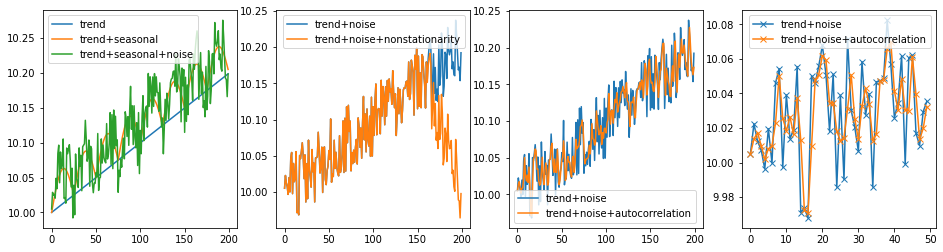

In [20]:
# Data and train, validation split
times = np.arange(200)
split = 100

fig, axes = plt.subplots(1, 4, figsize=(4*4,4))
axes = axes.ravel()

fmt='-'
ax = axes[0]
ax.plot(times, trend(times), fmt, label='trend')
ax.plot(times, trend(times)+seasonal(times), fmt, label='trend+seasonal')
ax.plot(times, trend(times)+seasonal(times)+noise(times), fmt,  label='trend+seasonal+noise')
ax.legend()

ax = axes[1]
ax.plot(times, trend(times)+noise(times), fmt, label='trend+noise')
ax.plot(times, trend(times)+noise(times)+nonstationarity(times), fmt, label='trend+noise+nonstationarity')
ax.legend()

ax = axes[2]
ax.plot(times, trend(times)+noise(times), fmt, label='trend+noise')
ax.plot(times, autocorrelation(trend(times)+noise(times)), fmt, label='trend+noise+autocorrelation')
ax.legend()

s=slice(0,50)
ax = axes[3]
fmt='-x'
ax.plot(times[s], (trend(times)+noise(times))[s], fmt, label='trend+noise')
ax.plot(times[s], autocorrelation(trend(times)+noise(times))[s], fmt, label='trend+noise+autocorrelation')
ax.legend();

# Moving-average regression, ARIMA 
[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) is a standard model for univariate timeseries prediction. The general form for an ARIMA model of a timeseries $X_t$ is

\begin{equation}
    \left(
    1 - \sum_{i=1}^p \Theta_i^{\text{AR}}L_i
    \right)
    \left(1-L\right)^d
    X_t
    = 
    \delta+
    \left(
    1 + \sum_{i=1}^q \Theta_i^{\text{MA}}L_i 
    \right) \varepsilon_t,
\end{equation}

where 

* $L_i$ is the *lag operator*, $L_i X_t = X_{t-i}$
* $\varepsilon_t$ are *error* terms at time $t$ (typically independent, identically normally distributed, with zero mean)
* $\delta$ is constant *drift* term (modeling a constant trend)

The integer hyperparameters $p, d, q$ determine the number and types of terms included in the model and they to correspond to the [AR](https://en.wikipedia.org/wiki/Autoregressive_model), I, and [MA](https://en.wikipedia.org/wiki/Moving-average_model) part of the ARIMA model, respectively. Thus, a specific ARIMA model can be specified as ARIMA$(p, d, q)$. Here $d$ stands for "difference" as it explicitly includes terms with the difference of  $X_t$ relative to past terms. For instance (assuming $\delta=0$)
* ARIMA(1, 0, 0) model is an 
    [AR(1)](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process) process,
    $X_t = \Theta_1^{\text{AR}} X_{t-1} + \varepsilon_t$
* ARIMA(0, 1, 0), or I(1), is a random walk, $X_t = X_{t-1} + \varepsilon_t$
* ARIMA(0, 0, 1) or MA(1) is a moving average $X_t = \varepsilon_t + \Theta_1^{\text{MA}}\varepsilon_{t-1}$ 

Both the AR and the MA part of the model use past times to model $X_t$ but in different ways. The MA terms incorporate a direct dependency on past error terms  $\varepsilon_{t-i}$, representing a noisy environment. The AR terms on the other hand, model a dependency on the past values of the signal itself. A major difference between the two is that the AR terms will propagate a fluctuation $\varepsilon_t$ to all future times $t'>t$, where the rate of decay is determined by the size of the coefficients $\Theta^{\text{AR}}$, whereas the MA terms will just include it for $q$ future times as a weighted average with weights determined by $\Theta^{\text{MA}}$.

## SARIMA
 *Seasonal ARIMA* (SARIMA) is an extension to ARIMA that incorporates seasonality by adding another "layer" of coefficients for modeling seasonal variations. SARIMA is specificed as ARIMA$(p,d,q)(P,D,Q)S$, where $S$ is the seasonality, e.g. $S=12$ for monthly data and $P, D, Q$ are the orders for the seasonal part of SARIMA. The seasonal terms simply multiply the regular ARIMA polynomial as

\begin{equation}
    \left(
    1 - \sum_{i=1}^p \Theta_i^{\text{AR}}L_i
    \right)
    \left(
    1 - \sum_{i=1}^P \Theta_i^{\text{SAR}}L_{iS}
    \right)
    \left(1-L\right)^d
    \left(1-L_S\right)^D
    X_t
    = 
    \delta+
    \left(
    1 + \sum_{i=1}^q \Theta_i^{\text{MA}}L_i 
    \right)
    \left(
    1 + \sum_{i=1}^Q \Theta_i^{\text{SMA}}L_{iS} 
    \right)
    \varepsilon_t.
\end{equation}

We see that the seasonal lag operators take strides of $S$, meaning  ARIMA$(p,d,q)(1, D, 1)$ will predict $X_t$ using terms $X_{t-S}$ and  ARIMA$(p,d,q)(2, D, 2)$ using also terms $X_{t-2S}$. More examples can be found [here](https://online.stat.psu.edu/stat510/lesson/4/4.1).

## More
There are additional generalizations to the ARIMA model, see for instance [this summary](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/).

# ARIMA in `statsmodels`
The ARIMA function from statsmodels supports both standard ARIMA and extensions, including SARIMA.  

Note: I here use the `statsmodels.tsa.arima.model.ARIMA` implementation. There is an alternative (newer) implementation `statsmodels.tsa.statespace.sarimax`.

In [874]:
def mse(y, yhat):
    return np.mean((y - yhat)**2)

def rmse(y, yhat):
    return np.sqrt(mse(y, yhat))

In [22]:
def predict_ARIMA(x, times, model, model_fit):
    "Make predictions for trained model using data x"
    tmp_model = ARIMA(x, order=model.order, trend=model.trend, seasonal_order=model.seasonal_order)
    tmp_fit = tmp_model.smooth(model_fit.params)
    yhat = tmp_fit.predict(times[0], times[-1])
    return yhat

I use artificial data consisting of trend+noise to get a feeling for the ARIMA models. Later I will make the data slightly more interesting by adding autocorrelation.

In [23]:
def evaluate_arima(order, seasonal_order=(0, 0, 0, 0), autocorr=False, seasons=False, seed=0):
    """Test ARIMA model for trend+noise data."""
    
    # Make data
    times=np.arange(200)
    x = trend(times) + noise(times, seed=seed)
    if seasons:
        x += seasonal(times, pattern=linear_pattern)
    if autocorr:
        x = autocorrelation(x)
    split=100
    
    # Define and fit model
    p, d, q = order
    P, D, Q, S = seasonal_order
    model_kwargs = {'order': order, 'seasonal_order': seasonal_order}
    
    # Add trend coefficients if there is differencing 
    if not d and not D:
        model_kwargs['trend'] = 'ct'
        
    model = ARIMA(x[:split], **model_kwargs)
    model_fit = model.fit()

    print("Model coefficients:")
    for k, v in zip(model_fit.param_names, model_fit.params):
        print(f"{k}: {v}")
    print("-"*80)
        
    # Predict on all times
    xhat = predict_ARIMA(x, times, model, model_fit)
    start = max(p, d, q)
    start = max(start, max(P, D, Q)*S)
    
    # Metrics
    print("Metrics:")
    print(f"RMSE train = {rmse(xhat[start:split], x[start:split]):.5f}")
    print(f"RMSE validation = {rmse(xhat[split:], x[split:]):.5f}")
    print("-"*80)
    
    # Plot all times
    s = slice(start, None)
    plt.plot(x[s], 'x', label='Data')
    plt.plot(xhat[s], '-', label=f'Model')
    if not autocorr:
        plt.plot(trend(times)[s],'--', label='Real trend')

    plt.axvline(x=split, linestyle=':', color='gray', label='Train/validation split')
    plt.legend()
    plt.title(f"ARIMA{model.order}");

    # PLot first times
    plt.figure()
    s = slice(start, 50)
    plt.plot(x[s], 'x-', label='Data')
    plt.plot(xhat[s], 'x-', label=f'Model')
    if not autocorr:
        plt.plot(trend(times)[s],'--', label='Real trend')
    plt.legend()
    plt.title(f"ARIMA{model.order}");

# Trend+noise data

## MA model, ARIMA(0, 0, 1)
To begin, let's evaluate a MA(1) model:

Model coefficients:
const: 10.009037963397267
x1: 0.0007473548624547947
ma.L1: -0.0739745885538348
sigma2: 0.0008043574235979121
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02785
RMSE validation = 0.04289
--------------------------------------------------------------------------------


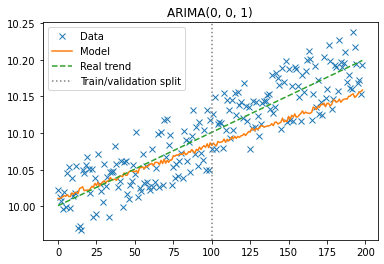

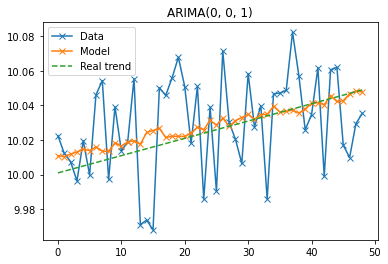

In [23]:
evaluate_arima((0, 0, 1))

Clearly, the slope obtained from fitting on the training data was off, leading to big errors in the validation data set. The RMSE obtained from the training set is optimistic. We see that even a small error in the slope will  lead to large errors on the y-axis for large times. Note that a simple linear model will suffer from the same issue. 

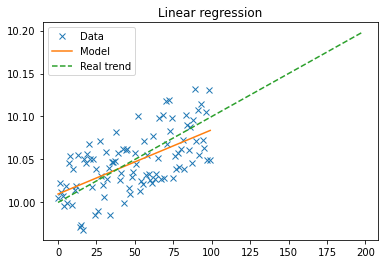

In [24]:
# Ordinary least squares, linear model: y = ax + b
times
y = trend(times)+noise(times)
X = np.column_stack((np.ones(len(times)), times))
ols_model = sm.OLS(y[:split], X[:split,:])
ols_fit = ols_model.fit()
yhat = ols_fit.predict(X[:split, :])
plt.plot(y[:split], 'x', label='Data')
plt.plot(yhat, label="Model")
plt.plot(trend(times)[:-1], '--', label='Real trend')
plt.legend()
plt.title("Linear regression");

## Difference model, ARIMA(0, 1, 0)
The issues we saw previously of finding the "perfect" slope, also accurate for long timeseries, is reduced for a simple difference/random walk model, I(1). For this model the next step is always predicted to be the current step, there is no slope, and there can be no gradual increase in errors. For being a naive model without any parameters to fit, it performs pretty well, at least better than the MA(1) model. However, when zooming in we see that there are still rather large errors due to the noise. Also, the larger the slope, the worse this model would perform.

Model coefficients:
sigma2: 0.0017727956943741645
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.04211
RMSE validation = 0.04014
--------------------------------------------------------------------------------


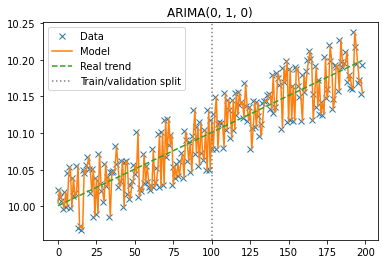

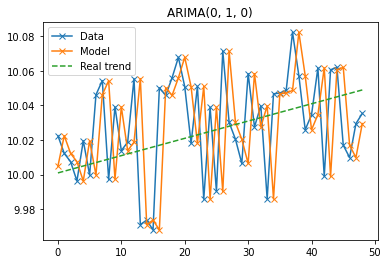

In [25]:
evaluate_arima((0, 1, 0))

## IMA model, ARIMA(0, 1, 1)
The I(1) model can be improved by adding MA term. We see that this smoothens the predictions and reduces the error significantly.

Model coefficients:
ma.L1: -0.8769372666496205
sigma2: 0.000891864761077701
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02993
RMSE validation = 0.02989
--------------------------------------------------------------------------------


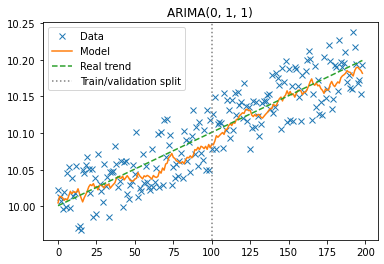

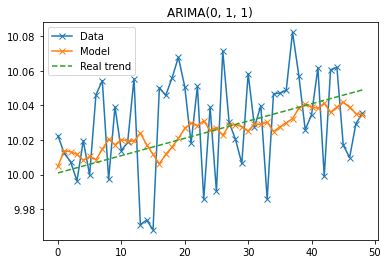

In [26]:
evaluate_arima((0, 1, 1))

## AR model, ARIMA (1, 0, 0)
Finally, we can investigate a simple AR(1) model. However, we see that this suffers from the same slope issue as the MA(1) model.

Model coefficients:
const: 10.009037963397267
x1: 0.0007473548624548165
ar.L1: -0.13792381628194067
sigma2: 0.0007708846521832891
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02776
RMSE validation = 0.04431
--------------------------------------------------------------------------------


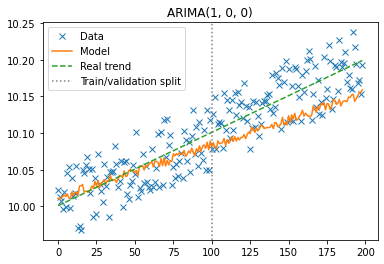

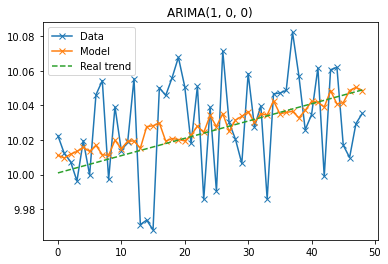

In [27]:
evaluate_arima((1, 0, 0))

Complementing it by IMA terms, we get simular results as for the ARIMA(0, 1, 1) model.

Model coefficients:
ar.L1: -0.15852023699158155
ma.L1: -0.8407961549582519
sigma2: 0.0008742844525848267
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.02963
RMSE validation = 0.02966
--------------------------------------------------------------------------------


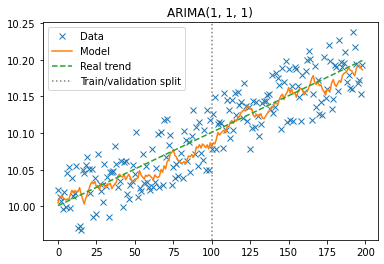

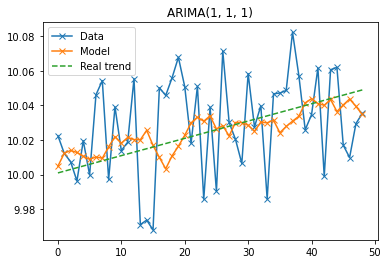

In [28]:
evaluate_arima((1, 1, 1))

## Summary
For the trend+noise dataset the ARIMA(1,1,1) with validation RMSE=0.02966 performed the best, followed closely by ARIMA(0, 1, 1) model with RMSE=0.02989. This amounts to a modest relative difference in RMSE of about 1%. The AR(1) model performed the worst with validation RMSE=0.04431.

# Trend+noise+autocorrelation data
Here we add 1-lag autocorrelation term to the signal, so we expect a model with AR terms to  have some advantage.

## ARIMA(0, 1, 1)

Model coefficients:
ma.L1: 0.15437167395283843
sigma2: 0.00029288396624868184
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.01712
RMSE validation = 0.01877
--------------------------------------------------------------------------------


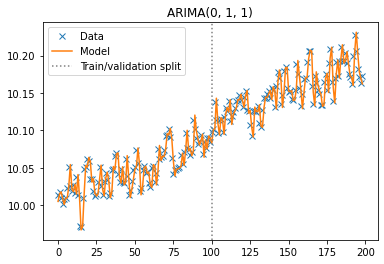

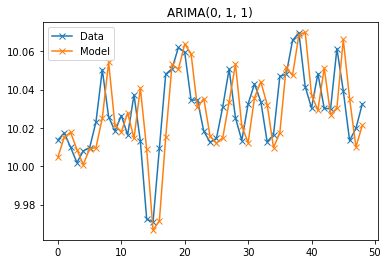

In [29]:
evaluate_arima((0, 1, 1), autocorr=True)

## ARIMA(1, 1, 1)
However, now the ARIMA(1,1,1)

Model coefficients:
ar.L1: -0.6286324919455285
ma.L1: 0.9525112384510628
sigma2: 0.00025251595224636724
--------------------------------------------------------------------------------
Metrics:
RMSE train = 0.01595
RMSE validation = 0.01694
--------------------------------------------------------------------------------


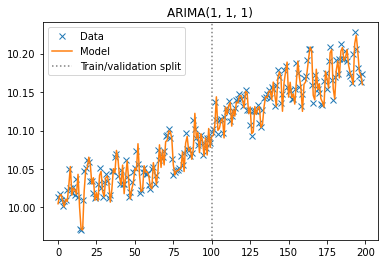

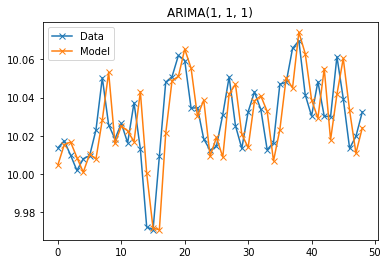

In [30]:
evaluate_arima((1, 1, 1), autocorr=True)

Indeed, there ARIMA(1,1,1) has a ~10% lower RMSE than ARIMA(0,1,1) (compared to 1% difference when there was no autocorrelation). Note that running `evaluate_arima` with another seed, reproduces this result.

# TODO
- Seasonal ARIMA, for instance tutorial on [Statsmodel's SARIMAX](https://www.statsmodels.org/dev/examples/index.html#state-space-models)

# See also
- [Tutorial on timeseries modeling using ARIMA](https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089)

# Feed-forward neural network model for timeseries
A fully-connected neural network can also be used for time-series predictions. Here, I use Tensorflow for this purpose.

## Prepare dataset
First, generate an artifical timeseries dataset:

In [506]:
def generate_data(autocorr=False, seasons=False, seed=0, num_times=200):
    times=np.arange(num_times)
    x = trend(times) + noise(times, seed=seed)
    if seasons:
        x += seasonal(times, pattern=linear_pattern)
    if autocorr:
        x = autocorrelation(x)
    return x

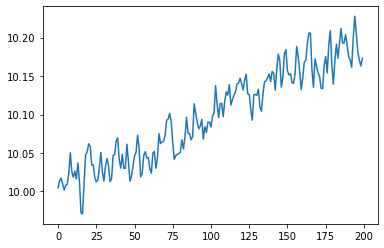

In [837]:
x = generate_data(autocorr=True)
split = 100
x_train, x_valid = x[:split], x[split:]
times_train, times_valid = times[:split], times[split:]

plt.plot(x);

The network takes as input a segments of the timeseries of a given window size, and uses that to predict the last element in the window. I.e., 
$[x_{t-w}, x_{t-w+1}, ..., x_{t-1}] \to x_t$. Tensorflow's `Dataset`  helps us to define this mapping:

In [838]:
# Based on: https://www.tensorflow.org/guide/data#time_series_windowing

def window_dataset(ds, window_size=5, shift=1, stride=1):
    """Return windowed dataset."""
    if isinstance(ds, np.ndarray):
        ds = tf.data.Dataset.from_tensor_slices(ds)
    
    # Perform windowing. Result is nested, a dataset of "windows",
    # where each window is itself a dataset.
    windows = ds.window(window_size, shift=shift, stride=stride)

    # Transform window dataset into to batch datasets (with 1 sample)
    # and flatten results (concatenate batch datasets)
    def window_to_batch(window):
        # Make sure all windows are the same size by dropping remainder, if any.
        return window.batch(window_size, drop_remainder=True)

    windows = windows.flat_map(window_to_batch)

    return windows

In [839]:
def make_dataset(x, window_size=5, shuffle_buffer_size=None, batch_size=None):
    """Form input-to-output windows."""
    
    # Make windows of given size for predicting the value after the window (+1)
    # Elements: [x_i, ..., x_{i+w}]
    ds = window_dataset(x, window_size=window_size+1)

    # Map window of window_size-1 element (input) to last element (output)
    # Elements (tuple): ([x_i, ..., x_{i+w-1}], x_{i+w})
    #return ds.map(lambda z: z[-1])
    ds = ds.map(lambda z: (z[:-1], z[-1:]))
    
    # Shuffle and batch
    if shuffle_buffer_size:
        ds = ds.shuffle(shuffle_buffer_size)
    if batch_size:
        # Allow the last batch to be smaller
        ds = ds.batch(batch_size, drop_remainder=False)
    
    return ds

In [842]:
def make_prediction_dataset(x, window_size=5, batch_size=None):
    """Form input-to-output windows."""
    
    # Make windows of given size for predicting the value after the window (+1)
    # Elements: [x_i, ..., x_{i+w}]
    ds = window_dataset(x, window_size=window_size+1)

    # Map window of window_size-1 element (input) to last element (output)
    # Elements (tuple): ([x_i, ..., x_{i+w-1}], x_{i+w})
    #return ds.map(lambda z: z[-1])
    ds = ds.map(lambda z: (z[:-1], z[-1:]))
    
    # Shuffle and batch
    if shuffle_buffer_size:
        ds = ds.shuffle(shuffle_buffer_size)
    if batch_size:
        # Allow the last batch to be smaller
        ds = ds.batch(batch_size, drop_remainder=False)
    
    return ds

These are the windowed input and the output times that are fed to the network during training:

In [843]:
# Config
window_size=5

ds_times = make_dataset(times_train, window_size=window_size)
print("Input, output:")
for t in ds_times.take(5):
    print(f"{t[0].numpy()}, {t[1].numpy()}")

Input, output:
[0 1 2 3 4], [5]
[1 2 3 4 5], [6]
[2 3 4 5 6], [7]
[3 4 5 6 7], [8]
[4 5 6 7 8], [9]


For training, the data is also shuffled and batched:

In [844]:
ds_times = make_dataset(times_train, window_size=window_size, shuffle_buffer_size=len(times_train), batch_size=32)
print("Times:")
for t in ds_times.take(5):
    # Print first sample in batch
    print(f"\nBatch shapes; input: {t[0].shape}, output: {t[1].shape}")
    print(f"First sample in batch:")
    print(f"{t[0].numpy()[0]}, {t[1].numpy()[0]}")

Times:

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[75 76 77 78 79], [80]

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[49 50 51 52 53], [54]

Batch shapes; input: (31, 5), output: (31, 1)
First sample in batch:
[93 94 95 96 97], [98]


Of course, it's the data of those time indices that is used for training.

In [845]:
ds = make_dataset(x_train, window_size=window_size, shuffle_buffer_size=len(x_train), batch_size=32)

print("Input, output:")
for t in ds.take(5):
    # Print first sample in batch
    print(f"\nBatch shapes; input: {t[0].shape}, output: {t[1].shape}")
    print(f"First sample in batch:")
    print(f"{t[0].numpy()[0]}, {t[1].numpy()[0]}")

Input, output:

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[10.05209795 10.03025545 10.04281114 10.07510207 10.06222536], [10.06444096]

Batch shapes; input: (32, 5), output: (32, 1)
First sample in batch:
[10.05138812 10.06713901 10.05533507 10.07049136 10.09642457], [10.07602638]

Batch shapes; input: (31, 5), output: (31, 1)
First sample in batch:
[10.01635932 10.03727441 10.01311943  9.97241482  9.97085309], [10.00934855]


## Model definition
The model architecture is defined by a number of fully connected layers:

In [846]:
def neural_network(input_shape, output_shape, num_nodes=10, activation='relu'):
    model = tf.keras.Sequential()
    
    #  Allow more general input shape
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    
    # Add layers with given number of nodes.
    # Nodes can be iterable or integer (single layer)
    if isinstance(num_nodes, int):
        num_nodes = [num_nodes]
    for num in num_nodes:
        model.add(tf.keras.layers.Dense(num, activation=activation))

    # Output layer (allow for more general output shape)
    num_out = 1
    for num in output_shape:
        if num:
            num_out *= num
    model.add(tf.keras.layers.Dense(num_out))
    model.add(tf.keras.layers.Reshape(output_shape))

    return model

Note that the model depends on the window size, since it needs to know the input and output shapes.

In [847]:
# Ignore batch dimension of tensorflow tensor shapes
input_shape, output_shape = (tuple((dim for dim in spec.shape if dim)) for spec in ds.element_spec)
print(input_shape, output_shape)

(5,) (1,)


In [848]:
# config
num_nodes = [10, 10]

model = neural_network(input_shape, output_shape, num_nodes=num_nodes)
model.summary()

# We could also produce a graph with the code below, but it requires having graphviz installed
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 5)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_61 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 11        
_________________________________________________________________
reshape_20 (Reshape)         (None, 1)                 0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


The flatten and reshape layer just takes care of flattening the input and reshaping the output for the case of a multivariate timeseries, but doesn't add any extra parameters. Each layer $i$ transforms the input vector $x$ of length $n_i$ into an output vector of length $n_{i+1}$ by a linear transformation $Wx + b$, where $W$ is a $(n_i \times n_{i+1})$-matrix and $b$ is a $n_{i+1}$-length bias vector. Each layer thus adds $n_i\times n_{i+1} + n_{i+1}$ parameters. Here,

In [849]:
print("Number of parameters:")
print(f"Layer 1: {input_shape[0]*num_nodes[0]+num_nodes[0]}")
print(f"Layer 2: {num_nodes[0]*num_nodes[1]+num_nodes[1]}")
print(f"Output layer: {num_nodes[1]*output_shape[0] + output_shape[0]}")

Number of parameters:
Layer 1: 60
Layer 2: 110
Output layer: 11


The activation function $h$, here defaulting to be a [ReLu function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), adds nonlinearity to the model. The total transformation of a layer including the activation is is $x' = h(Ax + b)$. The `None` shape referes to an arbitrary batch shape, chosen $>1$ for more efficient parallelized training.
The same network can be visualized 

## Training

In [850]:
# Config
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
    loss=tf.keras.losses.MeanSquaredError(),
)

In [851]:
# Train
history = model.fit(
    ds,
    epochs=1000,
    verbose=0,
)

In [852]:
rmse_train = np.sqrt(history.history['loss'])
min(rmse_train) #, min(rmse_valid)

0.02083735633603667

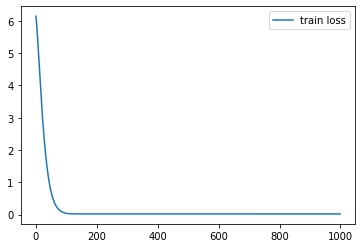

In [868]:
rmse_hist = np.sqrt(history.history['loss'])
plt.plot(rmse_hist, label='train loss')
plt.legend();

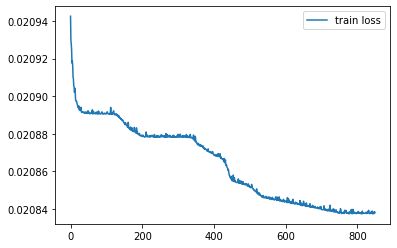

In [873]:
s = slice(150, None)
plt.plot(rmse_hist[s], label='train loss')
plt.legend();

# Predict/validate

In [855]:
# Make predictions for whole dataset
# Note: need batch_size >= 1 , model expects it.
ds_pred = make_dataset(x, window_size=window_size, batch_size=1)

# Split input ("x") and output ("y")
# y is the target
ds_x = ds_pred.map(lambda x, y: x)
ds_y = ds_pred.map(lambda x, y: y)

# Flatten the output as much as possible to be compatible with the output of `model.predict`
ds_y = ds_y.unbatch()
try:
    ds_y = ds_y.unbatch()
except:
    pass

#y = list(ds_y.as_numpy_iterator())
y = np.fromiter(ds_y.as_numpy_iterator(), dtype=ds_y.element_spec.dtype.as_numpy_dtype)

In [856]:
print("Dataset elements (first sample):")
first_x, first_y = next(ds_x.as_numpy_iterator()), next(ds_y.as_numpy_iterator())
print(f"Input: {first_x}")
print(f"Output: {first_y}")

Dataset elements (first sample):
Input: [[10.00488135 10.01374446 10.0173719  10.0098703  10.00189895]]
Output: 10.008035797206643


Note that the first predicted value is the `window_size`th value:

In [857]:
print(np.isclose(x[:window_size], first_x).all() and np.isclose(x[window_size], first_y))

True


In [858]:
yhat = model.predict(ds_x).ravel()
assert yhat.shape == y.shape

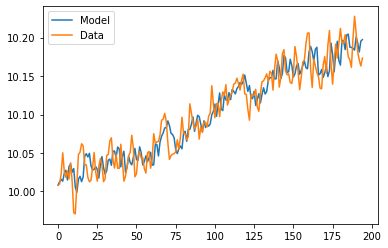

In [862]:
start=0
s = slice(start, None)
plt.plot(yhat[s], '-', label='Model')
plt.plot(y[s], '-', label='Data')
plt.legend()

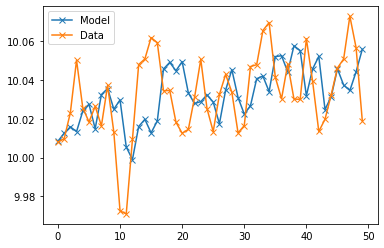

In [863]:
s = slice(start, 50)
plt.plot(yhat[s], 'x-', label='Model')
plt.plot(y[s], 'x-', label='Data')
plt.legend()

In [877]:
rmse(y[:split], yhat[:split]), rmse(y[split:], yhat[split:])

(0.02077078094319547, 0.02133664877023033)

## TODO: hyperparameter optimization (learning rate)